In [158]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
olympics=0
if olympics==1:
    dataset=pd.read_csv('./Data/olympics_100m.csv')
else:
    dataset=pd.read_csv('./Data/test.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


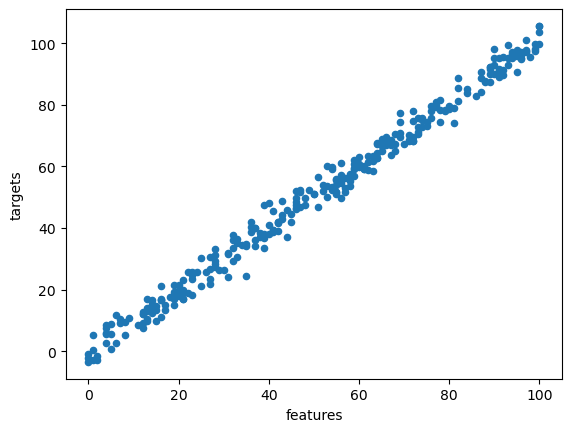

In [159]:
#plot
if dataset.shape[1]==2:
    dataset.plot.scatter(x='features',y='targets')

In [160]:
from ridge import Ridge_Regression
X=dataset.drop('targets',axis=1).values.reshape(-1,dataset.shape[1]-1)
Y=dataset['targets'].values.reshape(-1,1)
## given the low amount of data available we decided to do a K-fold cross validation
## the parameter lambda follows a coarse to fine approach
## the coarse search is done with a step of 0.1 and the fine search with a step of 0.01
lambda_values=np.linspace(0,90000000,num=(900+1))
k=5
fold_size=int(len(X)/k)
# generate the intervals for the coarse to fine approach from 1 to 10^-20
for subinterval in np.array(10.0 ** np.arange(6, -20, -1)):
    lambda_mses=[]
    print('subinterval: ',subinterval)
    for lambda_value in lambda_values:
        ridge=Ridge_Regression(lambda_value)
        mses=[]
        for i in range(k):
            # K-fold cross validation (take the data from the i-th fold as test data)
            Xi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0)
            Yi=np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
            mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
        print('lambda: ',lambda_value,' mse: ',np.mean(mses))
    print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
    lambda_values=np.linspace(max(lambda_values[np.argmin(lambda_mses)]-1*subinterval,0),lambda_values[np.argmin(lambda_mses)]+1*subinterval,num=(20+1))
lambda_value=lambda_values[np.argmin(lambda_mses)]

subinterval:  1000000.0
lambda:  0.0  mse:  9.290018886569474
lambda:  100000.0  mse:  50.560767644385535
lambda:  200000.0  mse:  143.30655464180023
lambda:  300000.0  mse:  259.0952983450712
lambda:  400000.0  mse:  383.2629226787536
lambda:  500000.0  mse:  508.1246728685857
lambda:  600000.0  mse:  629.6826551653178
lambda:  700000.0  mse:  745.9427313523499
lambda:  800000.0  mse:  856.0190966618147
lambda:  900000.0  mse:  959.6426627904675
lambda:  1000000.0  mse:  1056.884537581452
lambda:  1100000.0  mse:  1147.9977743528236
lambda:  1200000.0  mse:  1233.3258699832006
lambda:  1300000.0  mse:  1313.2497364679534
lambda:  1400000.0  mse:  1388.1572139305856
lambda:  1500000.0  mse:  1458.4259454541275
lambda:  1600000.0  mse:  1524.4142249630772
lambda:  1700000.0  mse:  1586.456606131957
lambda:  1800000.0  mse:  1644.8623348467693
lambda:  1900000.0  mse:  1699.9154266574885
lambda:  2000000.0  mse:  1751.875668999483
lambda:  2100000.0  mse:  1800.9801080231293
lambda:  220

In [161]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y)
x=np.array([2010,2012,2014,2016,2018,2020]).reshape(-1,1)
y_pred=ridge.Predict(x.reshape(-1,1))
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(x.reshape(-1,1))
for i in range(len(X)):
    print('year: ',X[i],' time: ',Y[i])
for i in range(len(x)):
    print('year: ',x[i],' time: ',y_pred[i])
    print('scikit: year: ',x[i],' time: ',y_pred_sklearn[i])
    
print('w_mio: ',ridge.__str__())
print('w_sklearn: ',ridge_sklearn.coef_,ridge_sklearn.intercept_)

year:  [77]  time:  [79.77515201]
year:  [21]  time:  [23.17727887]
year:  [22]  time:  [25.60926156]
year:  [20]  time:  [17.85738813]
year:  [36]  time:  [41.84986439]
year:  [15]  time:  [9.80523488]
year:  [62]  time:  [58.87465933]
year:  [95]  time:  [97.61793701]
year:  [20]  time:  [18.39512747]
year:  [5]  time:  [8.74674765]
year:  [4]  time:  [2.81141583]
year:  [19]  time:  [17.09537241]
year:  [96]  time:  [95.14907176]
year:  [62]  time:  [61.38800663]
year:  [36]  time:  [40.24701716]
year:  [15]  time:  [14.82248589]
year:  [65]  time:  [66.95806869]
year:  [14]  time:  [16.63507984]
year:  [87]  time:  [90.65513736]
year:  [69]  time:  [77.22982636]
year:  [89]  time:  [92.11906278]
year:  [51]  time:  [46.91387709]
year:  [89]  time:  [89.82634442]
year:  [27]  time:  [21.71380347]
year:  [97]  time:  [97.41206981]
year:  [58]  time:  [57.01631363]
year:  [79]  time:  [78.31056542]
year:  [21]  time:  [19.1315097]
year:  [93]  time:  [93.03483388]
year:  [27]  time:  

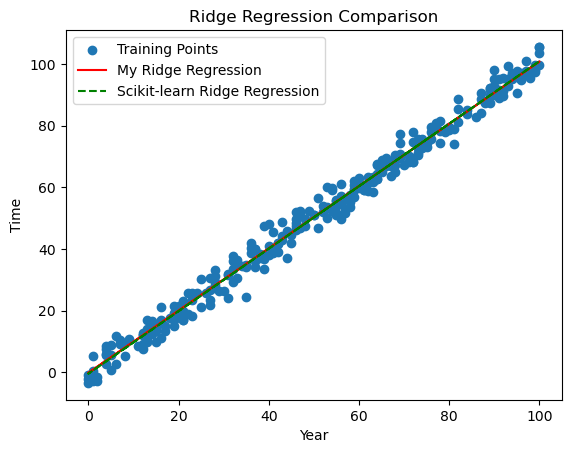

In [162]:
import matplotlib.pyplot as plt   
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y)
y_pred=ridge.Predict(X)
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(X)
plt.scatter(X, Y, label='Training Points')
plt.plot(X, y_pred, label='My Ridge Regression', color='red')
plt.plot(X, y_pred_sklearn, label='Scikit-learn Ridge Regression', linestyle='--', color='green')

plt.title('Ridge Regression Comparison')
plt.xlabel('Year')
plt.ylabel('Time')
plt.legend()
plt.show()